In [1]:
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import io
import requests 
from bs4 import BeautifulSoup
import time
from matplotlib.lines import Line2D
import os
import csv
from os import listdir
from scipy import ndimage
from scipy import stats
from scipy import signal
from HPGe import *

### Plot of Labelled Sample Spectrum

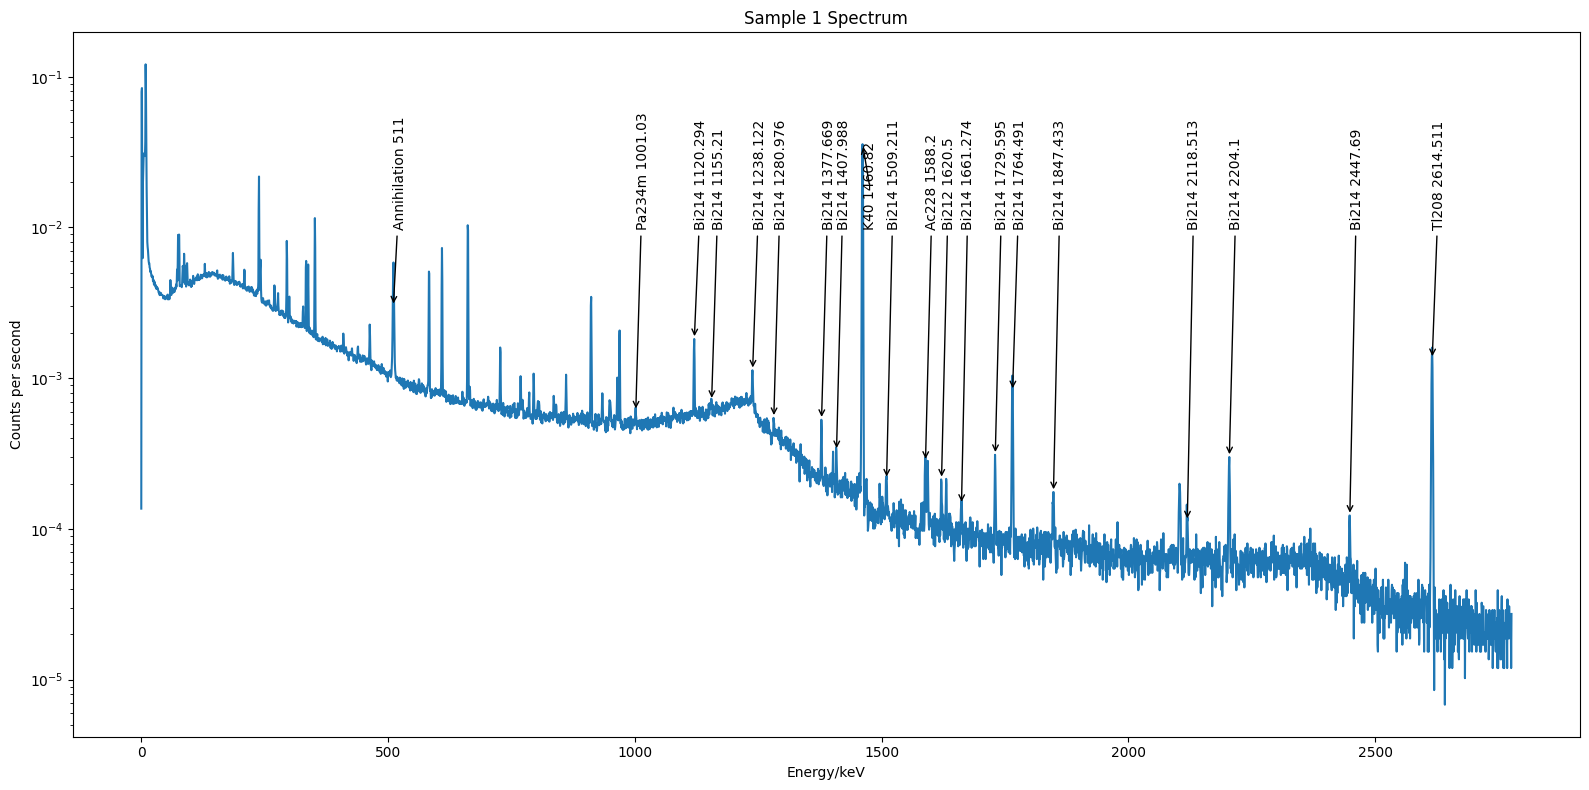

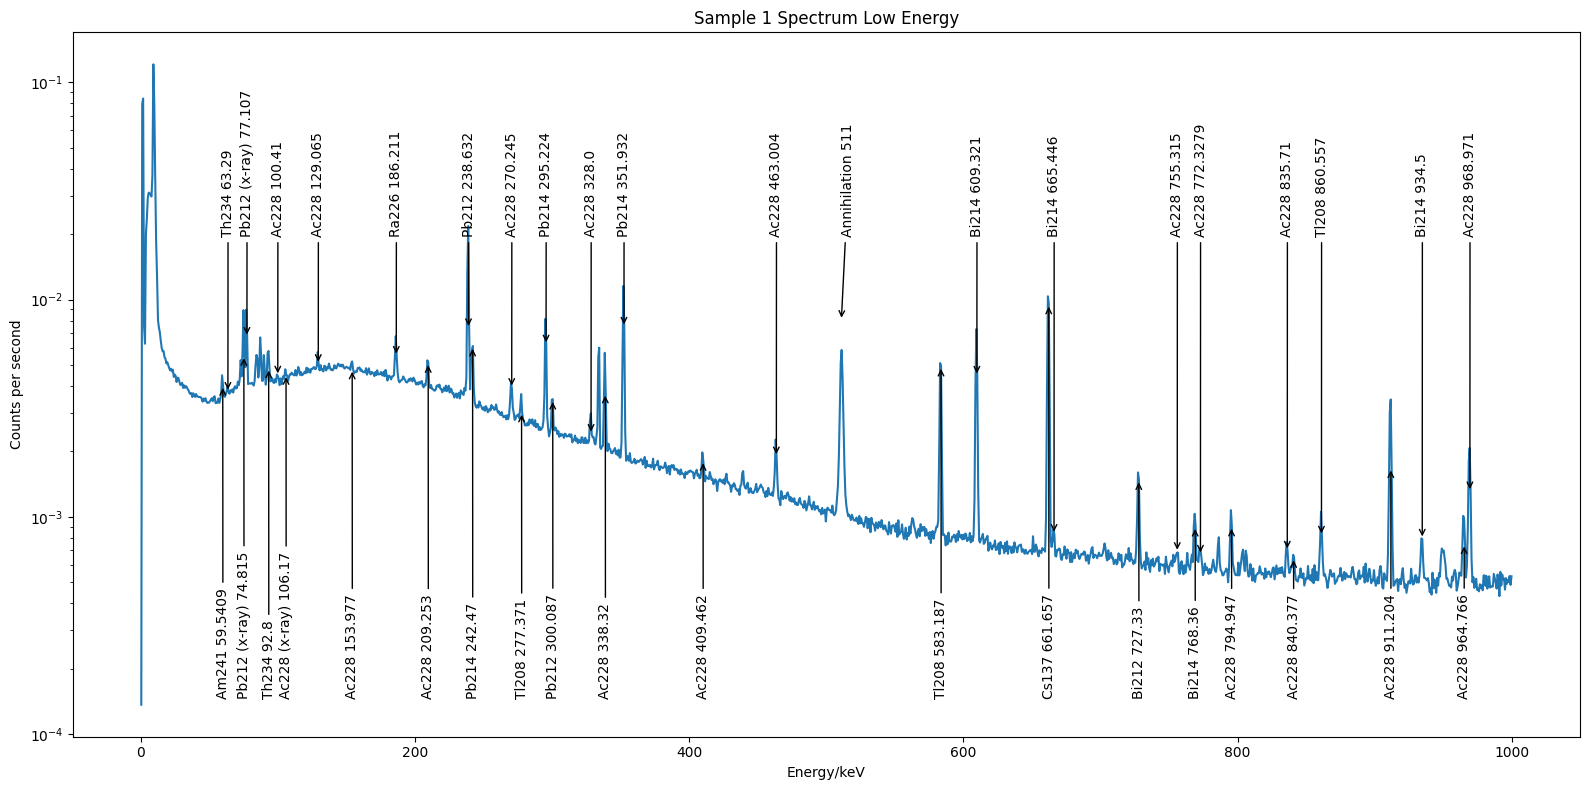

In [2]:
Spec(1).plot()

In [3]:
marker_list = list(Line2D.markers.keys())

In [4]:
Spectra().df

,Filename,Live time/s,Real time/s,Total CPS
0,Background_16_10_23_Mon_14_50.csv,353069.86,354394.61,1.041791
1,HPGe_21.02.2022_background.csv,1204602.50,1209121.82,2.596276
2,HPGe_Background_12.12.23.csv,411527.06,413117.24,1.946662
3,HPGe_Sample3_07.12.23.csv,777953.97,780963.11,0.447947
4,IAEA_Sample_20_11_23_Mon_10_58.csv,589490.43,591717.78,0.668286
5,IAEA_sample_05.12.22 copy.csv,1191067.75,1195547.14,4.114920
6,Sample1_23_10_23_Mon_10_39.csv,586551.55,588791.75,4.144091
7,Sample2_31_10_23_14_08.csv,690516.01,693190.81,4.447199
8,Sample3_07_11_23_Tue_11_50.csv,592161.76,594479.48,2.488062
9,Sample4_13_11_23_Mon_14_06.csv,523881.40,525880.09,4.665623


In [5]:
sample_df = pd.DataFrame(
{'Sample':[1,2,3,4,'IAEA-385'],
'Depth/cm':['0-10','10-20','20-30','30-40','--'],
'Beaker mass/kg':[0.0583,0.0576,0.0581,0.0581,0], 
'Gross mass/kg':[0.4279,0.5733,0.5399,0.5585,0]})
sample_df['Net mass/kg'] = sample_df['Gross mass/kg'] - sample_df['Beaker mass/kg']
sample_df.loc[4,'Net mass/kg'] =0.05
# print(sample_df.to_latex(index = False,column_format = 'c|c|c|c|c'))
# list(sample_df['Net mass/kg'])

In [6]:
def err_prop(data,err):
    '''Error propagation for effect of rescaling sample 3 data'''
    S_err_S = Spec(3).S_err/Spec(3).S
    err_data = err/data
    return data*Spec(3).S * np.sqrt(S_err_S**2 + err_data**2)

In [7]:
print('scaling factor and its error',Spec(3).S,Spec(3).S_err)

scaling factor and its error 1.9002867527141494 0.05437774972003003


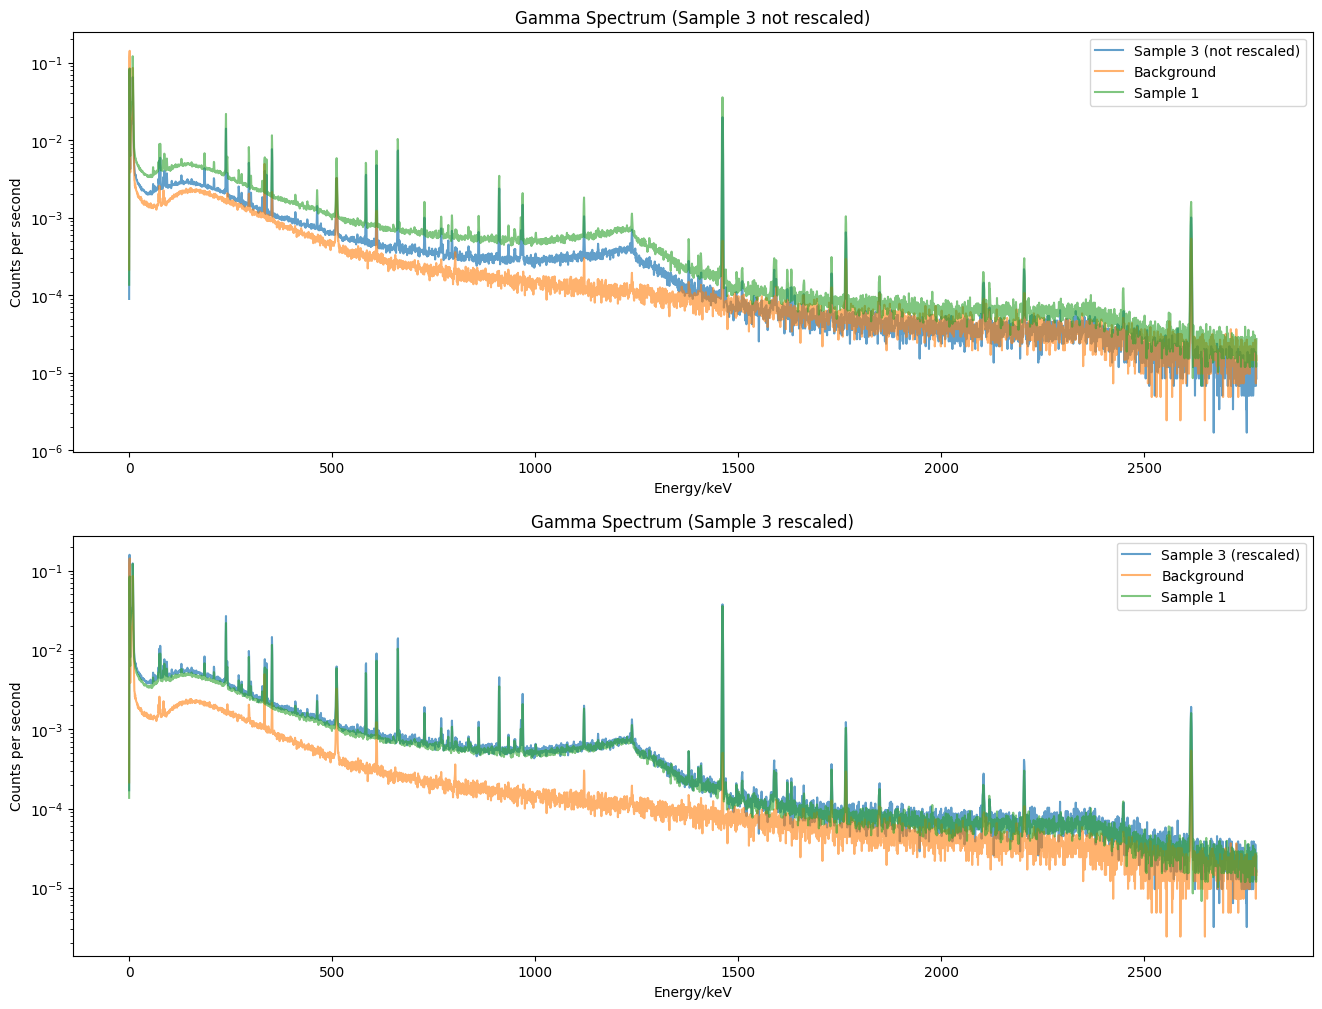

In [8]:
label_list = ['Background', 'Sample 1', 'Sample 2', 'Sample 3', 'Sample 4','IAEA-385']
fig, ax = plt.subplots(nrows = 2, ncols = 1,figsize= (16,12))
ax[0].set_title('Gamma Spectrum (Sample 3 not rescaled)')
ax[1].set_title('Gamma Spectrum (Sample 3 rescaled)')
ax[0].plot(Spec(3).E,Spec(3).cps/Spec(3).S,alpha = 0.7,label = 'Sample 3 (not rescaled)')
ax[1].plot(Spec(3).E,Spec(3).cps,alpha = 0.7,label = 'Sample 3 (rescaled)') 
for n in range(2):
    for i in [0,1]:
        ax[n].plot(Spec(i).E,Spec(i).cps,label=label_list[i],alpha = 0.6)
    ax[n].legend()
    ax[n].set_ylabel('Counts per second')
    ax[n].set_xlabel('Energy/keV')
    ax[n].set_yscale('log')
plt.savefig('Plot Images/sample3_rescale.pdf')

### Am241 ingrowth correction

When a parent decays into the daughter nuclide, rate of cahnge of daughter atoms is the difference between rate of growth from parent and rate of decay of itself. Solving the differential equation 
$$\frac{dN_D}{dt} = -\lambda_D N_D+\lambda_P N_P$$ 
gives
$$ A_D = \frac{\lambda_D}{\lambda_D-\lambda_P} A_{P0}(e^{-\lambda_P t}-e^{-\lambda_D t})+A_{D0}e^{-\lambda_D t}$$
$D, P$ denotes daughter and parent respectively. Initial activityies are  $A_{D0}, A_{P0}$. $A = \lambda N$

corrected: $4.45 \pm 0.23$ Bq/kg 


In [9]:
lambda_D = np.log(2)/1.365e10
lambda_P = np.log(2)/4.51e8  
time_string = "1 January, 2019"
ref = time.strptime(time_string, "%d %B, %Y") #time_struct object of decay correction reference date
now = time.strptime("5 December, 2022", "%d %B, %Y")
dt = time.mktime(now)-time.mktime(ref) #time (in seconds) passed
#initial certified activity of IAEA385 on 1/1/2019

def ingrowth(A_D0,A_P0,A_D0_err,A_P0_err,lambda_D ,lambda_P):
    A_D = lambda_D/(lambda_D-lambda_P)*A_P0*(np.exp(-lambda_P*dt)-np.exp(-lambda_D*dt)) + A_D0*np.exp(-lambda_D*dt)
    A_D_err = np.sqrt((lambda_D/(lambda_D-lambda_P)*(np.exp(-lambda_P*dt)-np.exp(-lambda_D*dt))*A_P0_err)**2
                 +(A_D0_err*np.exp(-lambda_D*dt))**2)
    return [A_D, A_D_err]
A_D0 = 4.42
A_P0 = 9.9
A_D0_err = 0.23
A_P0_err = 1


print('corrected Am241 activity', ingrowth(A_D0,A_P0,A_D0_err,A_P0_err,lambda_D,lambda_P))
print('corrected R226 activity', ingrowth(22.8 ,31.8,0.6,1.4,np.log(2)/5.0492e10,np.log(2)/2.379e12 ) )

corrected Am241 activity [4.448810064073606, 0.22862881301554963]
corrected R226 activity [22.81529365549371, 0.5989850827837179]


### Create DataFrame of all peaks csv files of different spectra
Order: background (12/12/2023), samples 1-4, IAEA385 (05/12/2022)

In [10]:
pk_path_ls = sorted(listdir('Data/Peaks_final'))[1:] #peak csv path list
#concat all modified peak dataframe
pk_path_ls = [pk_path_ls[1]] + pk_path_ls[2:] + [pk_path_ls[0]] #reorder such that: bg, sample 1-4, iaea
df = pd.concat([peak_df_new(peak_df('Data/Peaks_final/'+path)) for path in pk_path_ls],keys = range(len(pk_path_ls)))
m_arr = [1]+list(sample_df['Net mass/kg'])
#rescale sample 3
df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']] = df.loc[3,['Net_Area_Count','Peak_CPS','Peak_CPS_BR']].values * Spec(3).S
df.loc[3,'Net_Area_err'] = err_prop(df.loc[3,'Net_Area_Count'].values,df.loc[3,'Net_Area_err'].values) #error propagation
#correct Ra226 186.211keV line count rate
df.loc[df[df['nndc_peak_energy']==186.211].index,['Peak_CPS','Peak_CPS_BR']] *= 0.571
df['rel_err'] = df['Net_Area_err']/df['Net_Area_Count'] #relative error in area
df['Peak_CPS_BR_m'] = df['Peak_CPS_BR']/np.concatenate([np.full(len(df.loc[i]),m_arr[i])for i in range(6)]) #per mass

In [11]:
iaea_df = df.loc[5]
bg_df = df.loc[0]

In [12]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula

In [13]:
Spec(5)

### Efficiency Calibration using IAEA385 Sample

In [14]:
#Cs activity is corrected for half life
iaea_385 =pd.read_csv('IAEA385_ReferenceActivity_2019.csv',delimiter = ',') 
iaea_mass = 0.05 #kg
#merge activity to iaea peak df
iaea_df = df.loc[5].merge(iaea_385,on='Nuclide')
#peak background correction
#merge peak background dataframe with iaea peak dataframe
iaea_df = iaea_df.merge(df.loc[0][['nndc_peak_energy','Peak_CPS_BR','rel_err']], on = 'nndc_peak_energy', 
how = 'left', suffixes = ['','_bg']) #df.loc[0] contains background peaks
iaea_df.loc[:,'Peak_CPS_BR_bg'].fillna(0,inplace = True)
#corrected count per sec/BR
iaea_df['Peak_CPS_BR_corr'] = iaea_df['Peak_CPS_BR']-iaea_df['Peak_CPS_BR_bg']
iaea_df['Peak_CPS_BR_corr_err'] = np.sqrt((iaea_df['Peak_CPS_BR']*iaea_df['rel_err'])**2
                                    +(iaea_df['Peak_CPS_BR_bg']*iaea_df['rel_err_bg'])**2)
iaea_df['eff'] = iaea_df['Peak_CPS_BR_corr']/(iaea_df['Abs_Activity']*iaea_mass) #efficiency
# #correction for composite peak at 186.211 (Gilmore p.321)
# Ra226_index = iaea_df[iaea_df['nndc_peak_energy']==186.211].index
# iaea_df.loc[Ra226_index,'eff'] *= 0.571
#error propagation (assume poisson noise for peak cps error)
iaea_df['eff_err']=iaea_df['eff']* np.sqrt((iaea_df['Net_Area_err']/iaea_df['Net_Area_Count'])**2+
(iaea_df['Abs_Activity_Unc']/iaea_df['Abs_Activity'])**2 + 0.05**2) #0.05**2 from percentage error of mass

df = pd.concat([df.loc[i].merge(iaea_df[['nndc_peak_energy','Peak_CPS_BR_bg','rel_err_bg']],on = 'nndc_peak_energy',how = 'left')
      for i in range(len(pk_path_ls))],keys = range(len(pk_path_ls)))
df.fillna(0,inplace = True)

In [15]:
U235_U238_ratio_iaea = 0.007/0.993
U235_U238_ratio_nndc =0.7204/99.2742
print(U235_U238_ratio_iaea,U235_U238_ratio_nndc)

0.007049345417925478 0.007256668902897229


In [16]:
iaea_df['nndc_peak_energy'].unique()

array([  59.5409,   63.29  ,   92.8   ,  100.41  ,  129.065 ,  153.977 ,
        209.253 ,  270.245 ,  328.    ,  332.37  ,  338.32  ,  409.462 ,
        463.004 ,  755.315 ,  772.3279,  794.947 ,  835.71  ,  840.377 ,
        911.204 ,  964.766 ,  968.971 , 1588.2   , 1630.627 ,  186.211 ,
        238.632 ,  300.087 ,  242.47  ,  295.224 ,  351.932 ,  277.371 ,
        583.187 ,  860.557 , 2614.511 ,  609.321 ,  665.446 ,  768.36  ,
        934.5   , 1120.294 , 1155.21  , 1238.122 , 1280.976 , 1377.669 ,
       1407.988 , 1509.211 , 1661.274 , 1729.595 , 1764.491 , 1847.433 ,
       2118.513 , 2204.1   , 2447.69  ,  661.657 ,  727.33  , 1620.5   ,
       1460.82  ])

efficiency fit parameters: [-2.44591423e+04  4.04578570e+02 -4.04548974e+00 -2.21065474e-04]
efficiency fit parameters errors: [2.09044357e+03 4.18226030e+01 1.43782120e-01 8.83965742e-05]


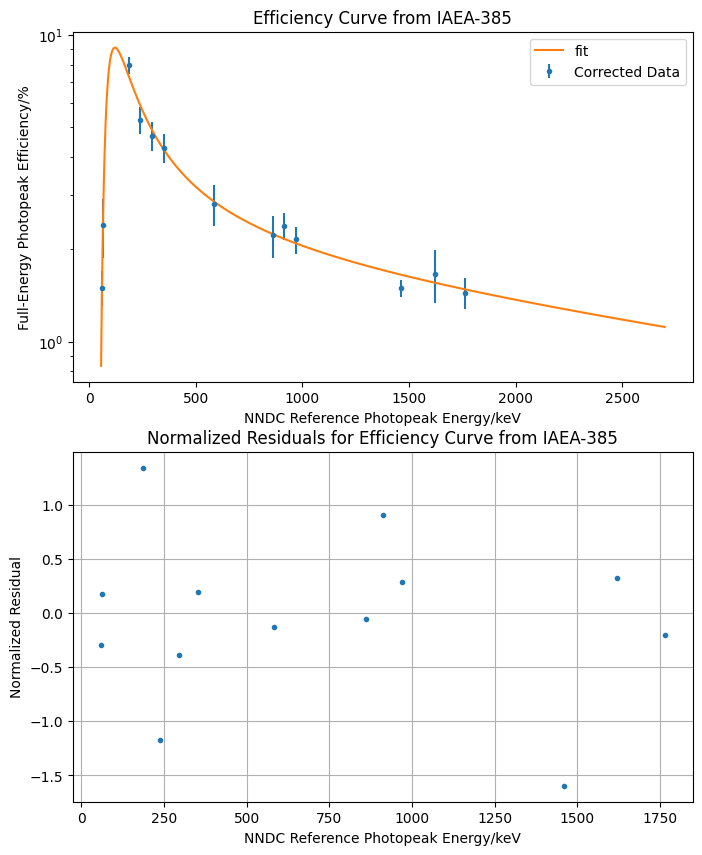

In [17]:
def eff_fit(x,a,b,c,d):
    '''Efficiency fit function
       x: energy (independent variable)
       p: parameter array
       this form of equation is suggested in Gilmore p.193'''
    return d*x+np.poly1d([a,b,c])(1/x)
    
U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
Th232_E = [ 911.204 ,  968.971 , 238.632, 1620.5,583.187,860.557]
eff_df = iaea_df[iaea_df['nndc_peak_energy'].isin(U238_E+Th232_E+[59.5409,1460.82])]
x_eff = eff_df['nndc_peak_energy']
eff_par, eff_cov = curve_fit(eff_fit,x_eff,np.log(eff_df['eff']))
eff_par_err = np.sqrt(np.diag(eff_cov))
print('efficiency fit parameters:', eff_par)
print('efficiency fit parameters errors:',eff_par_err)

fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

ax[0].set_title('Efficiency Curve from IAEA-385')
ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
#ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*np.exp(eff_fit(np.linspace(55,2700,10000),*eff_par)),label = 'fit')
ax[0].set_xlabel('NNDC Reference Photopeak Energy/keV')
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
ax[1].plot(x_eff,(eff_df['eff']-np.exp(eff_fit(x_eff,*eff_par)))/eff_df['eff_err'],'.')
ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV')
ax[1].set_ylabel('Normalized Residual')
ax[1].grid()

In [18]:
# def eff_fit2(x,a,b,c):
#     '''Efficiency fit function
#        x: energy (independent variable)
#        p: parameter array
#        this form of equation is suggested in Gilmore p.193'''
#     return np.exp(np.poly1d([a,b,c])(1/x))
    
# U238_E = [63.29, 1001.030, 186.211,351.932 ,295.224, 1764.491 ]
# Th232_E = [ 911.204 ,  968.971 , 238.632, 1620.5,583.187,860.557]
# eff_df = iaea_df[iaea_df['nndc_peak_energy'].isin(U238_E+Th232_E+[59.5409,1460.82])]
# x_eff = eff_df['nndc_peak_energy']
# eff_par2, eff_cov2 = curve_fit(eff_fit2,x_eff,eff_df['eff'],p0 = [0.001,0.01,0.1])
# eff_par_err2= np.sqrt(np.diag(eff_cov2))
# print('efficiency fit parameters:', eff_par2)
# print('efficiency fit parameters errors:',eff_par_err2)

# fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (8,10))

# ax[0].set_title('Efficiency Curve from IAEA-385')
# ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
# ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
# ax[0].plot(np.linspace(55,2700,10000),100*eff_fit2(np.linspace(55,2700,10000),*eff_par2),label = 'fit')
# ax[0].set_xlabel('NNDC Reference Photoeak Energy/keV')
# ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%')
# #plt.xscale('log')
# ax[0].set_yscale('log')
# ax[0].legend()

# ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385')
# ax[1].plot(x_eff,(eff_df['eff']-eff_fit2(x_eff,*eff_par2))/eff_df['eff_err'],'.')
# ax[1].set_xlabel('NNDC Reference Photoeak Energy/keV')
# ax[1].set_ylabel('Normalized Residual')
# ax[1].grid()

In [19]:
eff_cov


array([[ 4.36995430e+06, -8.67372043e+04,  2.76211090e+02,
        -1.54121075e-01],
       [-8.67372043e+04,  1.74913013e+03, -5.72333400e+00,
         3.23115088e-03],
       [ 2.76211090e+02, -5.72333400e+00,  2.06732982e-02,
        -1.21861980e-05],
       [-1.54121075e-01,  3.23115088e-03, -1.21861980e-05,
         7.81395432e-09]])

Consider  a function $Z(x,a,b,c)$, where a,b,c are parameters to be fitted.
$$\sigma_Z^2(x) = v^T(x) C v(x)$$
where $v := [\partial_aZ|_x \ \partial_bZ|_x\  \partial_cZ|_x]^T$ and $C$ is the covariance matrix

In [20]:
df['eff'] = np.exp(eff_fit(df['nndc_peak_energy'],*eff_par))
#partial derivatives of efficiency function w.r.t parameters a, b, c
eff_d = df['eff']*df['nndc_peak_energy']
eff_c = df['eff']
eff_b = df['eff']/df['nndc_peak_energy']
eff_a = df['eff']/df['nndc_peak_energy']**2
partial_eff = np.array([eff_a,eff_b,eff_c,eff_d])
#variance of efficiency, calculatedusing covariance matrix 
#take the diagonal entries, as the vectors v should be evaluated at the same energy
df['eff_err'] = np.sqrt(np.diag(np.dot(partial_eff.T,np.dot(eff_cov,partial_eff))))

### Energy, $FWHM^2$ Calibration

In [21]:
#calibration dataframe (IAEA285)
cal_E = [ 270.245,  277.371,  
        351.932,  463.004,  583.187,  609.321,  661.657,  727.33 ,
        860.557,  911.204,  934.5  ,  1120.294,
       1238.122, 1377.669 , 1620.5  , 1630.627, 1729.595,
       1764.491, 1847.433, 2204.1 ]
cal_df = df.loc[5][df.loc[5]['nndc_peak_energy'].isin(cal_E)]


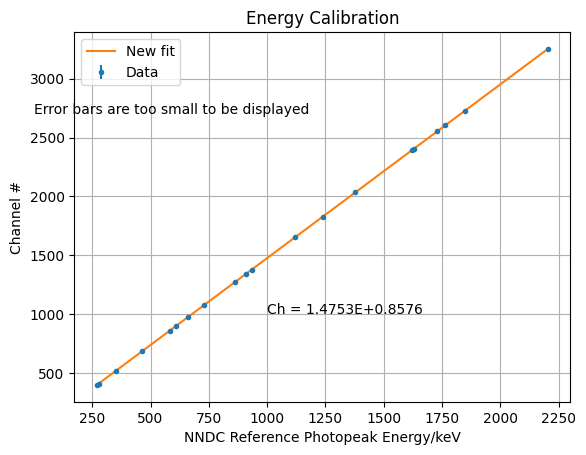

In [22]:
#convert peak energy to channel number (fraction of channel number) using Lynx calibration
#Lynx calibration: energy = a * Ch^2 + b*Ch + c
a = 8.387880257e-8
b = 0.6775230169
c = -0.3439140022

energy_to_chan = lambda x : (-b + np.sqrt(b**2-4*a*(c-x)))/2/a #quadratic formula


x = cal_df['nndc_peak_energy']
y = energy_to_chan(cal_df['Centroid'])
y_err = 1/np.sqrt(b**2-4*a*(c-x))*cal_df['Centroid_err']
E_par, E_cov = np.polyfit(x,y,1,cov = True) #energy callibration using peak
E_err= np.sqrt(np.diag(E_cov))
E_fit = np.poly1d(E_par)

#errorbars are too small to be displayed
plt.title('Energy Calibration')
plt.errorbar(x,y,yerr= y_err, fmt = '.',label = 'Data')
plt.plot(x,E_fit(x),label = 'New fit')
plt.legend()
plt.ylabel('Channel #')
plt.xlabel('NNDC Reference Photopeak Energy/keV')
plt.text(1000,1000,f'Ch = {E_par[0]:.4f}E+{E_par[1]:.4f}')
plt.text(1,2700,'Error bars are too small to be displayed')
plt.grid()

In [23]:
E_err

array([9.36143027e-05, 1.12643818e-01])

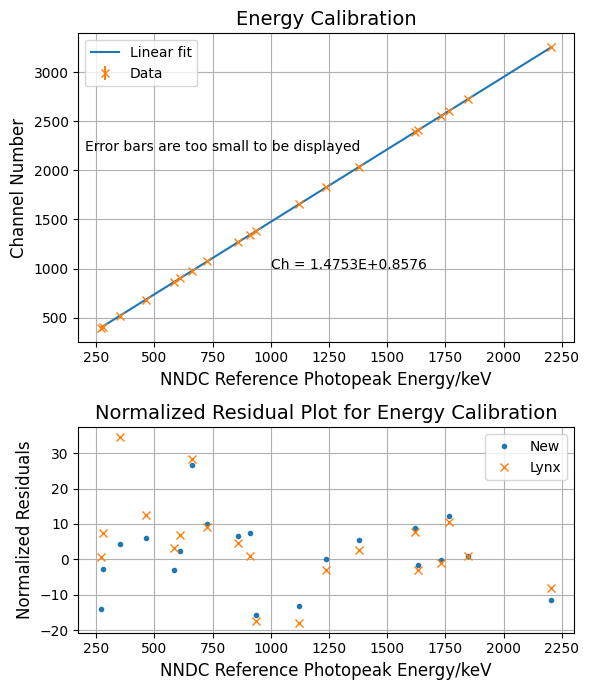

In [24]:
label_size = 12
title_size = 14
fig_E,ax_E = plt.subplots(2,1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})
ax_E[0].set_title('Energy Calibration',fontsize=title_size)
ax_E[0].plot(x,E_fit(x),label= 'Linear fit')
ax_E[0].errorbar(x,y,yerr= y_err, fmt = 'x',label = 'Data')
ax_E[0].text(1000,1000,f'Ch = {E_par[0]:.4f}E+{E_par[1]:.4f}')
ax_E[0].text(200,2200,'Error bars are too small to be displayed')
ax_E[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_E[0].set_ylabel('Channel Number',fontsize=label_size)
ax_E[0].grid()
ax_E[0].legend()
ax_E[1].set_title('Normalized Residual Plot for Energy Calibration',fontsize=title_size)
ax_E[1].plot(x,(y-E_fit(x))/y_err,'.',label= 'New')
ax_E[1].plot(x,(y-energy_to_chan(x))/y_err,'x',label = 'Lynx')
ax_E[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_E[1].set_ylabel('Normalized Residuals',fontsize=label_size)
ax_E[1].grid()
ax_E[1].legend()
fig_E.tight_layout()
# ax[1].set_title('Residual Plot for Energy Calibration')
# ax[1].plot(x,(y-E_fit(x)),'.',label= 'New')
# ax[1].plot(x,(y-energy_to_chan(x)),'x',label = 'Lynx')
# ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV')
# ax[1].set_ylabel('Residuals')
# ax[1].grid()
# ax[1].legend()
plt.savefig('formal_report_plots/E_cal.pdf')

In [25]:
chi2_prob(energy_to_chan(x),y,y_err,len(y)-2)
chi2_prob(E_fit(x),y,y_err,len(y)-2)

 chi2: 3281.3526423985977 
 reduced chi2: 182.29736902214432
 chi2 p-value: 0.0
 chi2: 1998.30163458905 
 reduced chi2: 111.01675747716945
 chi2 p-value: 0.0


111.01675747716945

In [26]:
C_E_par = [1/E_par[0],-E_par[1]/E_par[0]] #channel to energy linear fit coefficients m,c: E = m*Ch+c
C_E_err = [E_err[0]/E_par[0]**2,abs(C_E_par[1]*np.sqrt(np.sum((E_err/E_par)**2)))] # error on C to E fit
C_E_par

[0.6778408319401389, -0.5812938547661186]

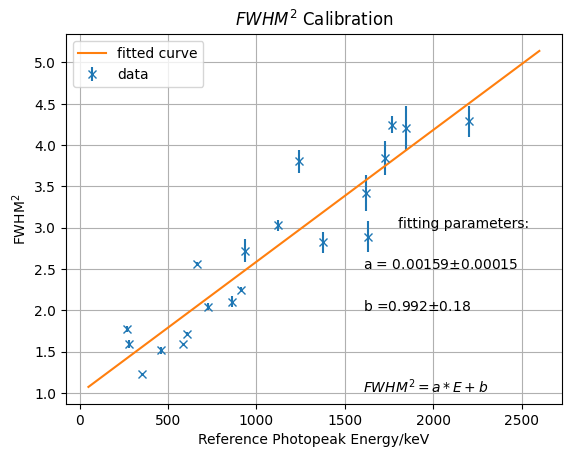

In [27]:
x_plot = np.linspace(50,2600,10000)
y_fwhm2 = cal_df['FWHM']**2
fwhm2_par,fwhm2_cov = np.polyfit(x,y_fwhm2, 1,cov = True)
fwhm2 = np.poly1d(fwhm2_par)
y_fwhm2_err = 2*cal_df['FWHM']*cal_df['FWHM_err']
fwhm2_err = np.sqrt(np.diag(fwhm2_cov))
plt.figure()
plt.title(r'$FWHM^2$ Calibration')
plt.errorbar(x,y_fwhm2,yerr = y_fwhm2_err,fmt = 'x',label = 'data')
plt.plot(x_plot,fwhm2(x_plot), label = 'fitted curve')
plt.ylabel(r'FWHM$^2$')
plt.xlabel('Reference Photopeak Energy/keV')
plt.legend()
plt.text(1800,3,f'fitting parameters:')
plt.text(1600,2.5,f'a = {fwhm2_par[0]:.3g}' + r'$\pm$'+ f'{fwhm2_err[0]:.3g}')
plt.text(1600,2,f'b ={fwhm2_par[1]:.3g}' + r'$\pm$'+ f'{fwhm2_err[1]:.3g}')
#plt.text(1600,1.5,f'c ={p_fwhm2[2]:.3g}' + r'$\pm$'+ f'{p_fwhm2_err[2]:.3g}')
plt.text(1600,1,r'$FWHM^2 = a * E+b$')
plt.grid()

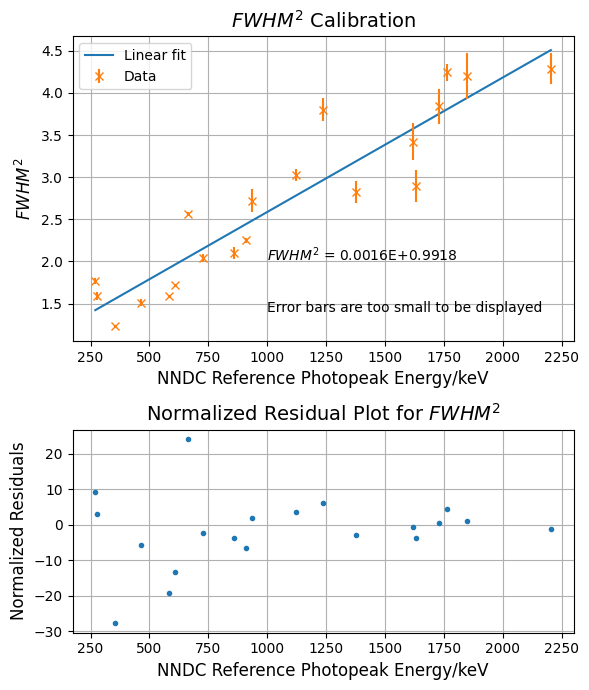

In [28]:
fig_fwhm,ax_fwhm = plt.subplots(2,1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})
ax_fwhm[0].set_title(r'$FWHM^2$ Calibration',fontsize=title_size)
ax_fwhm[0].plot(x,fwhm2(x),label= 'Linear fit')
ax_fwhm[0].errorbar(x,y_fwhm2,yerr= y_fwhm2_err, fmt = 'x',label = 'Data')
ax_fwhm[0].text(1000,2,r'$FWHM^2$'+f' = {fwhm2_par[0]:.4f}E+{fwhm2_par[1]:.4f}')
ax_fwhm[0].text(1000,1.4,'Error bars are too small to be displayed')
ax_fwhm[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_fwhm[0].set_ylabel(r'$FWHM^2$',fontsize=label_size)
ax_fwhm[0].grid()
ax_fwhm[0].legend()
ax_fwhm[1].set_title(r'Normalized Residual Plot for $FWHM^2$',fontsize=title_size)
ax_fwhm[1].plot(x,(y_fwhm2-fwhm2(x))/y_fwhm2_err,'.')
ax_fwhm[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize=label_size)
ax_fwhm[1].set_ylabel('Normalized Residuals',fontsize=label_size)
ax_fwhm[1].grid()
fig_fwhm.tight_layout()
plt.savefig('formal_report_plots/fwhm2_cal.pdf')

In [29]:
chi2_prob(fwhm2(x),y_fwhm2,y_fwhm2_err,len(y)-2)


 chi2: 2194.430996509056 
 reduced chi2: 121.912833139392
 chi2 p-value: 0.0


121.912833139392

In [30]:
fwhm2_par/2.35**2/2.96*1000

array([ 0.09757281, 60.67297654])

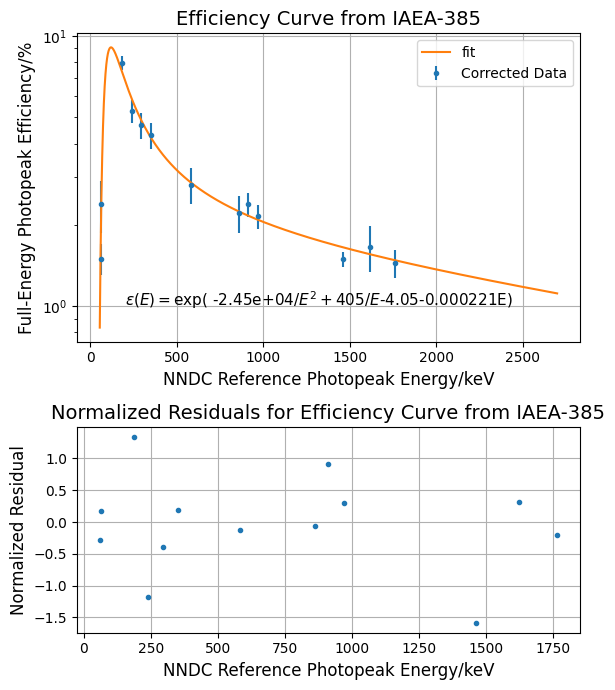

In [31]:
fig, ax = plt.subplots(nrows =2, ncols =1,figsize = (6,7), gridspec_kw={'height_ratios': [3, 2]})

ax[0].set_title('Efficiency Curve from IAEA-385',fontsize = title_size)
ax[0].errorbar(x_eff,100*eff_df['eff'],yerr =100*eff_df['eff_err'], fmt = '.',label = 'Corrected Data')
#ax[0].errorbar(x_eff,100*eff_df['Peak_CPS_BR']/(eff_df['Abs_Activity']*iaea_mass),yerr =100*eff_df['eff_err'], fmt = 'x',label = 'Original Data')
ax[0].plot(np.linspace(55,2700,10000),100*np.exp(eff_fit(np.linspace(55,2700,10000),*eff_par)),label = 'fit')
ax[0].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize = label_size)
ax[0].set_ylabel('Full-Energy Photopeak Efficiency/%',fontsize = label_size)
#plt.xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].grid()
ax[0].text(200,1,r'$\varepsilon (E) = \exp ($'+f' {eff_par[0]:.3g}'+r'$/E^2 + $'
+f'{eff_par[1]:.3g}'+r'$/E $'+f'{eff_par[2]:.3g}'+f'{eff_par[3]:.3g}E)', fontsize = 11)

ax[1].set_title('Normalized Residuals for Efficiency Curve from IAEA-385',fontsize = title_size)
ax[1].plot(x_eff,(eff_df['eff']-np.exp(eff_fit(x_eff,*eff_par)))/eff_df['eff_err'],'.')
ax[1].set_xlabel('NNDC Reference Photopeak Energy/keV',fontsize = label_size)
ax[1].set_ylabel('Normalized Residual',fontsize = label_size)
ax[1].grid()

fig.tight_layout()
plt.savefig('formal_report_plots/eff_cal.pdf')

In [32]:
sample_mass = np.array([0.427-0.0583, 0.5733-0.0576,0.5399-0.0581,0.5585-0.0581 ])
live_time = np.array(Spec(0).live_time)
df['Peak_CPS_BR_corr'] = df['Peak_CPS_BR']-df['Peak_CPS_BR_bg']
df['Peak_CPS_BR_corr_err'] = np.sqrt((df['Peak_CPS_BR']*df['rel_err'])**2
                                    +(df['Peak_CPS_BR_bg']*df['rel_err_bg'])**2)
#pseudo activity per mass        
m_arr_2 = np.concatenate([np.full(len(df.loc[i]),m_arr[i])for i in range(6)]) #mass array compatible with df
df['pseudo_A'] = df['Peak_CPS_BR_corr']/df['eff']/m_arr_2
df['pseudo_A_err'] = df['pseudo_A']*np.sqrt((df['Peak_CPS_BR_corr_err']/df['Peak_CPS_BR_corr'])**2
                                           +(df['eff_err']/df['eff'])**2)
df[df['Nuclide']=='Ra226']['pseudo_A']

1  9     2.928530
2  8     2.581054
3  9     3.043796
4  9     2.730586
5  9    24.773014
Name: pseudo_A, dtype: float64

In [33]:
#print(cal_df[['nndc_peak_energy','Nuclide','Reduced_chi2']].to_latex(index=False))
#print(eff_df[['nndc_peak_energy','Nuclide','BR']].to_latex(index=False))

In [54]:
fit_df = pd.DataFrame({'Calibration':['Param','Param_err','reduced chi^2','cov'],
    'Energy':[E_par,E_err,chi2_prob(E_fit(x),y,y_err,len(x)-2),E_cov],
    'Energy (Lynx)':[[a,b,c],0,chi2_prob(energy_to_chan(x),y,y_err,len(x)-3),0],
    'FWHMM^2':[fwhm2_par,fwhm2_err,chi2_prob(fwhm2(x),y_fwhm2,y_fwhm2_err,len(x)-2),fwhm2_cov],
    'Efficiency' : [eff_par,eff_par_err,chi2_prob(np.exp(eff_fit(x_eff,*eff_par)),eff_df['eff'],eff_df['eff_err'], len(eff_df['eff'])-len(eff_par)),eff_cov]
    })
fit_df.set_index('Calibration',inplace = True)
fit_df_style = fit_df.style.format( precision=3,)
#print(fit_df_style.to_latex(column_format = 'c|c|c|c|c'))

 chi2: 1998.30163458905 
 reduced chi2: 111.01675747716945
 chi2 p-value: 0.0
 chi2: 3281.3526423985977 
 reduced chi2: 193.02074367050574
 chi2 p-value: 0.0
 chi2: 2194.430996509056 
 reduced chi2: 121.912833139392
 chi2 p-value: 0.0
 chi2: 7.1186146729641235 
 reduced chi2: 0.7909571858849026
 chi2 p-value: 0.6247713250407927


### 'Pseudo' Activities of Nuclides in Samples

Actual activity is not calculated as geometric efficiencies of sample marinelli beaker and IAEA385 bottle are unknown. However, it is assumed that these efficiencies are energy independent, hence not-yet-corrected efficiency calculated can be used to compare activity of different nuclide in samples of the same geometry. This activity is named 'psuedo' activity here.


In [45]:

class nuclide:
    def __init__(self,name):
        self.df = df[df['Nuclide']==name].loc[1:4].reset_index()
        self.cps = self.df['Peak_CPS'] 
        self.cps_err = self.df['Net_Area_err']/live_time[1:5]
        self.name = name
        self.pseudo_A = self.df['pseudo_A']
        self.pseudo_A_err = self.df['pseudo_A_err']
        self.E = self.df['nndc_peak_energy'][0]
    def plot_cps(self):
        plt.figure()
        plt.errorbar(np.arange(1,5,1),self.cps
        ,yerr = self.cps_err ,fmt='.')
        plt.ylabel('Counts per second')
        plt.xlabel('Sample No.')
        plt.title(f'{self.name} Peak Count per Seconds per unit mass')
        plt.xticks(range(1,5))
        #plt.savefig(f'/Plot Images/{name}_cps.pdf')

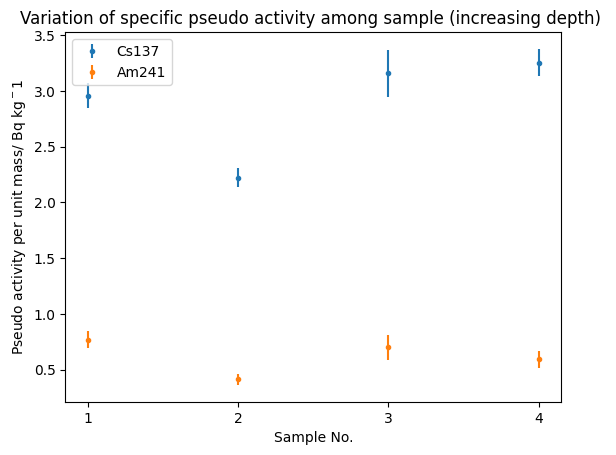

In [37]:
for nuc in ['Cs137','Am241']:
    plt.errorbar(np.arange(1,5,1),nuclide(nuc).pseudo_A
            ,yerr = nuclide(nuc).pseudo_A_err ,fmt='.',label = nuc)
    nuclide('Cs137').pseudo_A
    plt.ylabel(r'Pseudo activity per unit mass/ Bq kg$^-1$')
    plt.xlabel('Sample No.')
    plt.title('Variation of specific pseudo activity among sample (increasing depth) ')
    plt.xticks(range(1,5))
    plt.legend()
    plt.grid()

Text(0, 0.5, 'Pseudo Activity per mass/ Bq kg$^{-1}$')

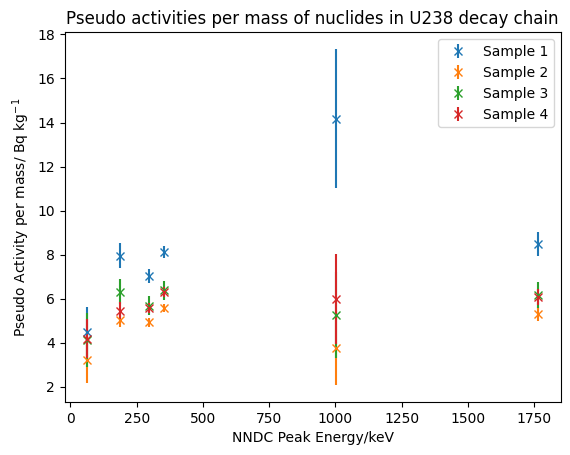

In [46]:
class chain:
    def __init__(self,E_arr):
        '''Output section of dataframe only with energies present in the E_arr'''
        self.df = df.loc[1:][df.loc[1:,'nndc_peak_energy'].isin(E_arr)]
        self.nuc = self.df['Nuclide']
    
U238_df = df[df['nndc_peak_energy'].isin(U238_E)]
chain(U238_E).df
plt.figure()
plt.title('Pseudo activities per mass of nuclides in U238 decay chain')
for i in range(4):
    plt.errorbar(U238_df.loc[i+1]['nndc_peak_energy'],U238_df.loc[i+1]['pseudo_A']/sample_mass[i]*np.array([1,1,1/1.051,1/0.996,1/1.231,1]),
    yerr= U238_df.loc[i+1]['pseudo_A_err']/sample_mass[i], fmt = 'x', label = f'Sample {i+1}')
    plt.legend()
plt.xlabel('NNDC Peak Energy/keV')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')

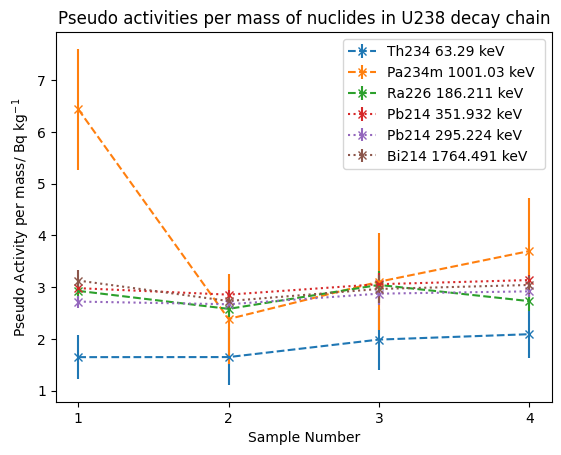

In [48]:
plt.title('Pseudo activities per mass of nuclides in U238 decay chain')
marker = ['x--', 'x--', 'x--', 'x:', 'x:', 'x:']
for i in range(len(U238_E)):
    E = U238_E[i]
    idx = chain(U238_E).df[chain(U238_E).df['nndc_peak_energy']==U238_E[i]].index
    nuc = chain(U238_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(U238_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/U238.pdf')

Text(0, 0.5, 'Pseudo Activity per mass/ Bq kg$^{-1}$')

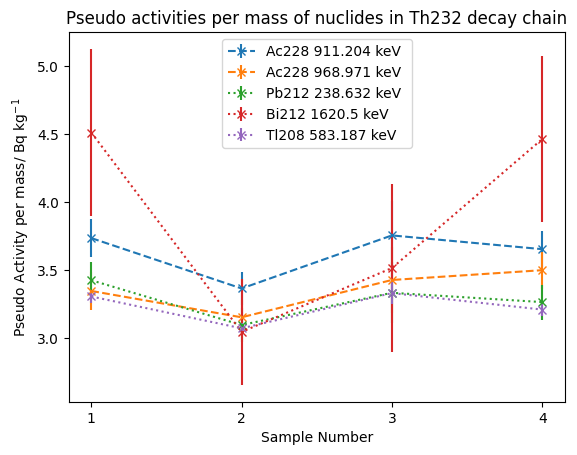

In [49]:
plt.title('Pseudo activities per mass of nuclides in Th232 decay chain')
marker = ['x--', 'x--', 'x:', 'x:', 'x:', 'x:']
Th232_scale = [1,1,1,1,1/0.3594] #rescale for branching ratio of Tl208 to give th232 equivalent
for i in range(len(Th232_E)-1):
    E = Th232_E[i]
    
    idx = chain(Th232_E).df[chain(Th232_E).df['nndc_peak_energy']==Th232_E[i]].index
    nuc = chain(Th232_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(Th232_E).df.loc[idx,'pseudo_A'][:-1]*Th232_scale[i], 
    yerr= chain(Th232_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
#plt.savefig('formal_report_plots/Th232.pdf')

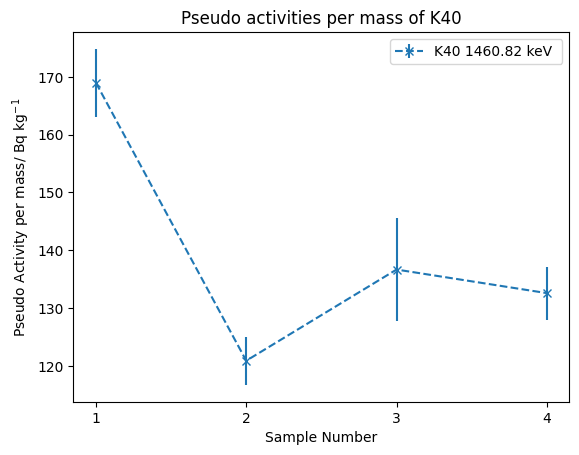

In [51]:
plt.title('Pseudo activities per mass of K40')
marker = ['x--', 'x--', 'x--', 'x:', 'x:', 'x:']
K40_E = [1460.82]
for i in range(len(K40_E)):
    E = K40_E[i]
    idx = chain(K40_E).df[chain(K40_E).df['nndc_peak_energy']==K40_E[i]].index
    nuc = chain(K40_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(K40_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(K40_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/K40.pdf')

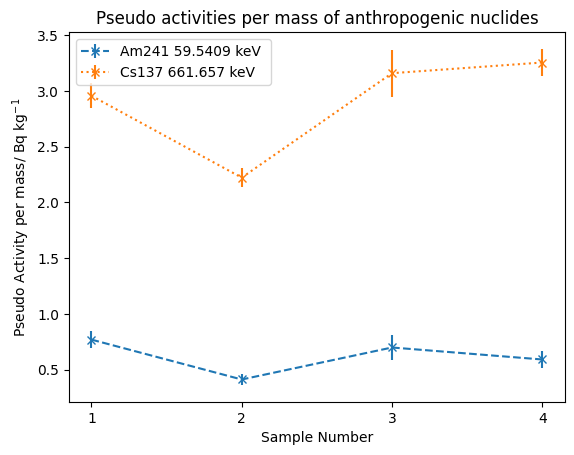

In [52]:
plt.title('Pseudo activities per mass of anthropogenic nuclides')
marker = ['x--', 'x:', 'x--', 'x:', 'x:', 'x:']
Am_Cs_E = [59.5409, 661.657]
for i in range(len(Am_Cs_E)):
    E = Am_Cs_E[i]
    idx = chain(Am_Cs_E).df[chain(Am_Cs_E).df['nndc_peak_energy']==Am_Cs_E[i]].index
    nuc = chain(Am_Cs_E).df.loc[idx[0],'Nuclide']
    plt.errorbar(np.arange(1,5),chain(Am_Cs_E).df.loc[idx,'pseudo_A'][:-1], 
    yerr= chain(Am_Cs_E).df.loc[idx,'pseudo_A_err'][:-1],
     fmt =marker[i],label = f'{nuc} {E} keV ')
    #plt.errorbar(np.arange(1,5),chain(U238_E).df.loc[idx,'pseudo_A'][:-1])
plt.legend()
plt.xticks(np.arange(1,5))
plt.xlabel('Sample Number')
plt.ylabel(r'Pseudo Activity per mass/ Bq kg$^{-1}$')
plt.savefig('formal_report_plots/Cs137_Am241.pdf')